# Analysis: Level of Abstraction

Using Wordnet, I will calculate the average level of abstraction of each description (estimated by the number of hypernyms of each word), and see if this changes across different time period or different culture.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
pd.options.display.max_columns = None
%matplotlib inline

In [2]:
df = pd.read_pickle("pickles/cleaned_df.pkl")

In [3]:
df.classification.unique()

array(['Paintings', 'Sculpture', 'Textile Arts',
       'Paintings with Calligraphy', 'Graphic Design', 'Photographs',
       'Prints'], dtype=object)

# Cleaning: periods
Cleaning up time periods

We will remove pre-15th centuries data. 

In [4]:
df = df[df.dateend >= 1500]

In [5]:
# re-binning for each time period
bins = [1500, 1860, 1900, 1950, 2000, 2020]
df['date_bins'] = pd.cut(df['dateend'], bins, labels = ["16th-19th_1st", "19th_2nd", "20th_1st", "20th_2nd", "21st"])



In [6]:
df.date_bins.value_counts('date_bins')

20th_1st         0.354722
20th_2nd         0.271810
16th-19th_1st    0.196107
19th_2nd         0.100937
21st             0.076424
Name: date_bins, dtype: float64

# Cleaning: macro culture

Adding a new column to categorize the culture

In [7]:
cnd = [
    df.culture.isin(['Korean', 'Japanese', 'Chinese', 'Tibetan', 'Thai']),
    df.culture == 'German', 
    (df.culture.str.contains("Italian") | df.culture.isin(['Minoan', 'British', 'Roman', 'French', 
                                                           'Spanish', 'European', 'Austrian', 'Portuguese',
                                                           'Graeco-Roman', 'Roman Provincial', 'Polish','Mycenaean',
                                                           'Hellenistic', 'Flemish', 'Belgian', 'Franco-Flemish', 
                                                           'Bohemian', 'British, English', 'Scottish', 'Etruscan',
                                                           'Netherlandish', 'Swiss', 'Czech', 'Norwegian', 'Croatian',
                                                          'Dutch', 'Slovenian', 'Yugoslav', 'Caucasian',
                                                           'Greek', 'Irish', 'English', 'Russian', 'Byzantine'])),
    df.culture.isin(['American', 'Canadian']), 
    df.culture.isin(['Indian', 'Mughal', 'Nepalese', 'Uzbek', 'Central Asian', 'Turkmen']), 
    df.culture.isin(['Peruvian', 'Mexican', 'Aztec', 'Central American', 'Venezuelan', 
                     'Brazilian', 'Argentinian', 'Teotihuacan']), 
    df.culture.isin(['Ethiopian', 'Moroccan', 'Coptic']), 
    df.culture.isin(['Persian', 'Iranian', 'Parthian', 'Cypriot', 'Afghan','Sumerian', 
                     'Hurrian', 'Mesopotamian', 'Syrian', 'Egyptian', 
                     'Cycladic', 'Phoenician', 'Anatolian','Syro-Hittite', 'Neo-Assyrian'
                    'South Arabia', 'Elamite', 'Turkish', 'Kurdish'])]
vals = ['East_Asian', 'German', 'European', 'North_American', 'Central_South_Asian', 'Central_South_American', 'African', 'Middle_East']
df['macro_culture'] = np.select(cnd, vals, default='others')

In [8]:
df.macro_culture.value_counts()

German                    979
North_American            555
European                  466
East_Asian                304
others                    285
Central_South_Asian       140
Central_South_American     25
Middle_East                21
Name: macro_culture, dtype: int64

# Hypenym Level
Calculating the level of hypernym for each unique word using Wordnet corpus

## Hypernym count data
First, making a dictionary with the number of hypernym

In [9]:
allwords = set([x for sub in df.description for x in sub]) # all unique value of nested list
len(allwords)

8470

In [10]:
from nltk.corpus import wordnet as wn

In [11]:
def hypernym (x):
    return x.hypernyms()

def find_hyp_level(word):
    n1 = wn.synsets(word, pos=wn.NOUN) # noun only
    if len(n1) == 0 : # if the word doesn't exist in Wordnet, return nan      
        #print(f"skipped {word}: morphed {wn.morphy(word)}") # skipped words and its morphed form
        return np.nan
    
    elif len(n1) == 1 : # if there's only one synset, take the length of all hypernym
        lev = len(list(n1[0].closure(hypernym)))
        if lev == 0: return -1
        else: return lev        
    
    else : # if there's more than one synset, take an average of all options 
        min_ = min([len(list(x.closure(hypernym))) for x in n1])
        if min_ == 0: return -1
        else: return min_


In [12]:
testwords = ['apple', 'fruit', 'food', 'matter', 'chocolate', 'cake', 'coin', 
             'cloud', 'happiness', 'sky', 'joy', 'mountain', 'landscape', 'alps', 'abstraction', 'light']
{k : find_hyp_level(k) for k in testwords}

{'apple': 13,
 'fruit': 7,
 'food': 4,
 'matter': 2,
 'chocolate': 5,
 'cake': 6,
 'coin': 8,
 'cloud': 3,
 'happiness': 5,
 'sky': 6,
 'joy': 6,
 'mountain': 5,
 'landscape': 7,
 'alps': -1,
 'abstraction': 1,
 'light': 5}

In [13]:
hyp_dict = {k : find_hyp_level(k) for k in allwords}

In [14]:
hyp_df = pd.DataFrame.from_dict(hyp_dict, 'index', columns = ['value']) # for easy data manipulation

In [15]:
hyp_df = hyp_df.replace(-1, np.nan)
#hyp_df = hyp_df.replace(-1, max(hyp_df.value)+1)

In [16]:
def hyp_score(list_):
    score = 0
    length = 0
    for word in list_:
        if ~np.isnan(hyp_df.loc[word])[0]:
            score += hyp_df.loc[word][0]
            length += 1
    if length > 0: return score /length
    else: return 0
    #return np.nansum([hyp_df.value[hyp_df.words == word] for word in list_])/len(list_)

In [17]:
df['hyp_score'] = df.description.apply(lambda x: hyp_score(x))

In [18]:
# re-binning for each time period
bins = [0, 5, 10, 15]
df['hyp_score_bins'] = pd.cut(df['hyp_score'], bins, labels = [0, 5, 10])

### Limitations / future direction
Currently I'm just averaging all occurrence in WordNet, this can be problematic for words that have multiple meanings especially if the abstraction level of each meaning is far apart. I also used only nouns, since different parts of speech have different level of hyper/hyponyms to gauge level of categorization accurately. In this process, some verbs that take same form as the noun cannot be filtered, possibly adding noise to our data.

# Average abstraction per culture
Hypothetically the level of hypernym is on average less for East Asian culture.

In [19]:
df_cl = df.dropna(subset = ['hyp_score_bins', 'hyp_score', 'macro_culture', 'date_bins'], axis = 0)

In [20]:
df_cl.groupby('macro_culture').hyp_score_bins.describe()

,count,unique,top,freq
macro_culture,,,,
Central_South_American,23,3,5,16
Central_South_Asian,140,2,5,137
East_Asian,302,3,5,269
European,445,3,5,383
German,973,3,5,909
Middle_East,21,2,5,20
North_American,513,3,5,434
others,285,2,5,262


In [21]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as st

In [22]:
cont_table = df_cl.groupby('macro_culture').hyp_score_bins.value_counts().unstack()
cont_table = cont_table.replace(np.nan, 0)

In [23]:
stat, p, dof, expected = st.chi2_contingency(cont_table)
print(f"Chi2 = {round(stat, 2)}, p = {round(p, 5)}")

Chi2 = 70.88, p = 0.0


In [24]:
cont_table

hyp_score_bins,0,5,10
macro_culture,,,
Central_South_American,6.0,16.0,1.0
Central_South_Asian,3.0,137.0,0.0
East_Asian,31.0,269.0,2.0
European,58.0,383.0,4.0
German,62.0,909.0,2.0
Middle_East,1.0,20.0,0.0
North_American,78.0,434.0,1.0
others,23.0,262.0,0.0


In [25]:
from itertools import combinations
combinations = list(combinations(cont_table.index, 2))

for c in combinations:

    sub_table = cont_table[(cont_table.index == c[0]) | (cont_table.index == c[1])]

    try:
        chi2, p, dof, ex = st.chi2_contingency(sub_table)
        print(f"{c}: Chi2 = {round(chi2, 2)}, p-value: {round(p, 2)}")
    except:
        print(f"{c} both has expected frequencies of zeros in one of the values.")

('Central_South_American', 'Central_South_Asian'): Chi2 = 28.28, p-value: 0.0
('Central_South_American', 'East_Asian'): Chi2 = 8.77, p-value: 0.01
('Central_South_American', 'European'): Chi2 = 5.86, p-value: 0.05
('Central_South_American', 'German'): Chi2 = 26.97, p-value: 0.0
('Central_South_American', 'Middle_East'): Chi2 = 4.94, p-value: 0.08
('Central_South_American', 'North_American'): Chi2 = 12.43, p-value: 0.0
('Central_South_American', 'others'): Chi2 = 20.91, p-value: 0.0
('Central_South_Asian', 'East_Asian'): Chi2 = 9.93, p-value: 0.01
('Central_South_Asian', 'European'): Chi2 = 15.04, p-value: 0.0
('Central_South_Asian', 'German'): Chi2 = 4.29, p-value: 0.12
('Central_South_Asian', 'Middle_East') both has expected frequencies of zeros in one of the values.
('Central_South_Asian', 'North_American'): Chi2 = 17.61, p-value: 0.0
('Central_South_Asian', 'others') both has expected frequencies of zeros in one of the values.
('East_Asian', 'European'): Chi2 = 1.47, p-value: 0.48
(

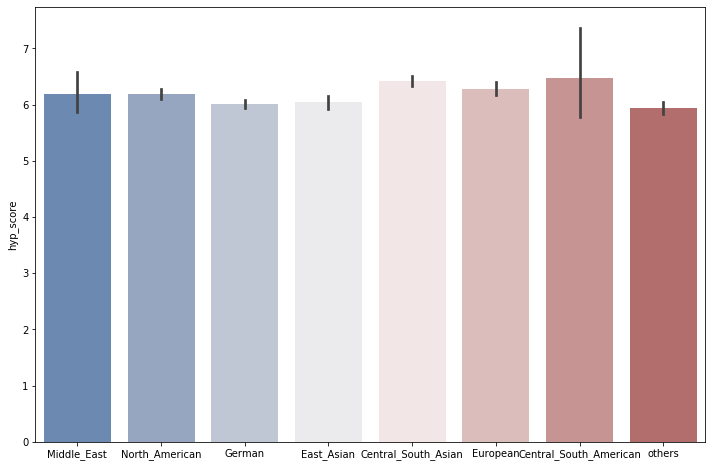

In [26]:
plt.figure(figsize = (12, 8))
sns.barplot(x = df_cl.macro_culture, y = df_cl.hyp_score, palette="vlag")
plt.xlabel('')
plt.show()

## Check frequent words
What's the significant difference in frequently used words between North American and European for instance.

In [27]:
from wordcloud import WordCloud

def count_words(list_):
    """
    input: list of preprocessed strings (refer to data preprocessing)
    output: dictionary of word counts for each unique words
    """
    # You can also use Counter from Collections package
    uniques = set(list_)
    counts = dict.fromkeys(uniques, 0)
    for word in list_:
        counts[word] += 1
    return {k: v for k, v in sorted(counts.items(), 
                                    reverse = True, key=lambda item: item[1])}
    
    
def plot_words(dict_, title, fname):
    """
    input: a dictionary of word counts, title of the graph (str), and a filename (str)
    output: barplot for first 30 words and wordcloud, and save out files
    """
    X = list(dict_.keys())[0:30]
    Y = list(dict_.values())[0:30]
    
    plt.figure(figsize=(8, 6))
    
    ax = sns.barplot(x=X, y=Y, palette="husl")
    ax.set(ylabel= 'counts', xlabel= '', title = title)
    ax.set_xticklabels(X, rotation=90) # rotate labels 90 degree
    
    plt.tight_layout() # make sure labels are not cropped in saved files
    plt.show()
    
    ax.figure.savefig(f"PNG/{fname}.png")
    
    wc = WordCloud(background_color="white", width=600, height=400, max_words=50)
    wc.generate_from_frequencies(dict_)

    plt.imshow(wc, interpolation="bilinear")
    
    wc.to_file(f"PNG/{fname}_wc.png")
    
    plt.axis("off")
    plt.show()


In [28]:
Central_South_Asian = sum(df_cl[df_cl.macro_culture == 'Central_South_Asian']['description'], [])
plot_words(count_words(East_Asian), 'Central_South_Asian', 'Central_South_Asian')




NameError: name 'East_Asian' is not defined

In [29]:
North_American = sum(df_cl[df_cl.macro_culture == 'North_American']['description'], [])
plot_words(count_words(European), 'North_American', 'North_American')



NameError: name 'European' is not defined

# Average abstraction per time period
Hypothetically the level of hypernym should get much lower around the industrial revolution and on when the abstract art started to happen.

In [30]:
df_eur = df_cl[df_cl.macro_culture == "European"]

In [31]:
df_eur.groupby('date_bins').hyp_score_bins.describe()

,count,unique,top,freq
date_bins,,,,
16th-19th_1st,207,3,5,183
19th_2nd,126,2,5,92
20th_1st,71,1,5,71
20th_2nd,21,3,5,17
21st,20,1,5,20


In [32]:
cont_table = df_eur.groupby('date_bins').hyp_score_bins.value_counts().unstack()
cont_table = cont_table.replace(np.nan, 0)

In [33]:
stat, p, dof, expected = st.chi2_contingency(cont_table)
print(f"Chi2 = {round(stat, 2)}, p = {round(p, 5)}")

Chi2 = 55.87, p = 0.0


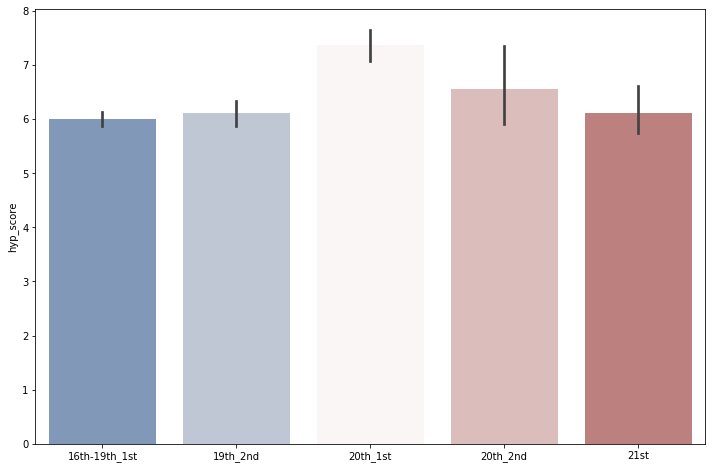

In [34]:
plt.figure(figsize = (12, 8))
sns.barplot(x = df_eur.date_bins, y = df_eur.hyp_score, palette="vlag")
plt.xlabel('')
plt.show()

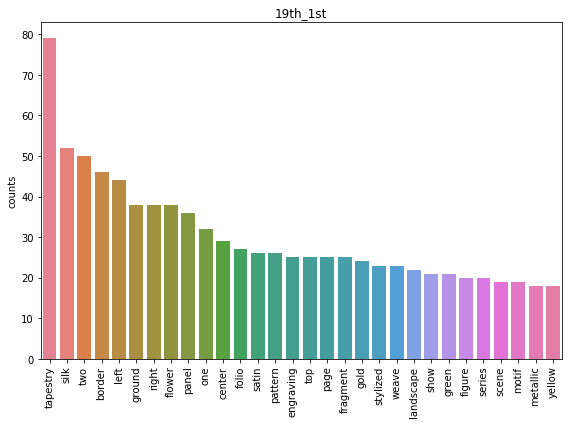

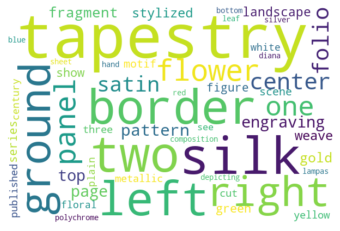

In [35]:
v1 = sum(df_eur[df_eur.date_bins == '16th-19th_1st']['description'], [])
plot_words(count_words(v1), '19th_1st', '19th_1st')

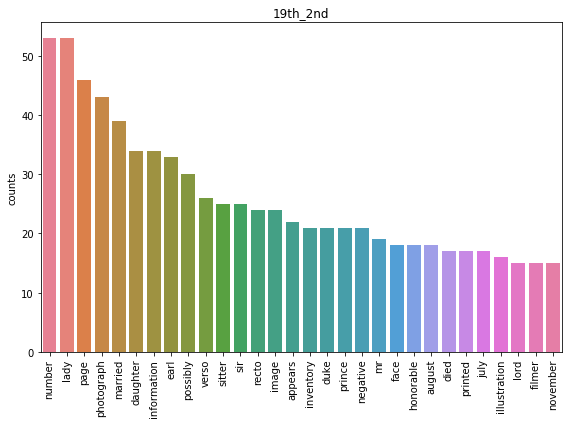

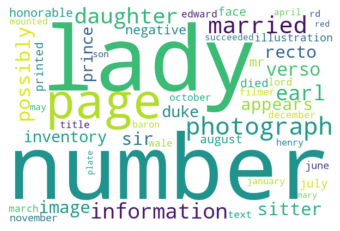

In [36]:
v2 = sum(df_eur[df_eur.date_bins == '19th_2nd']['description'], [])
plot_words(count_words(v2), '19th_2nd', '19th_2nd')

In [39]:
# saving pickle
filename = 'pickles/df_hypscore.pkl'
df.to_pickle(filename)